<a href="https://www.kaggle.com/aminizahra/quadratic-multiclass-classification-from-baise?scriptVersionId=88419875" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#import our library
import copy 
import warnings
import numpy as np 
import matplotlib.ticker as ticker
import scipy.sparse 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.stats import multivariate_normal
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
import math 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.metrics import accuracy_score

In [2]:
#Define cross point
def find_cross_point(y1, y2, y3):
    cross = np.zeros(2).astype(int)
    c = 0
    for i in range(1,y1.shape[0]+1):
        if np.round(y1[i-1],1)==5.7:
            cross[c] = i
            i += 50
            c += 1
        if c >= 2:
            break
    return cross

In [3]:
#define onehot key for our target
def to_onehot(Y): 
    m = Y.shape[0] 
    #Y = Y[:,0] 
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y[:,0], np.array(range(m))))) 
    OHX = np.array(OHX.todense()).T 
    return OHX

In [4]:
#calculate and load our dataset for 2 data sets and 3 classes
def load_data(mu1, cov1, n1, mu2, cov2, n2, mu3, cov3, n3, test_size):
    x1 = np.random.multivariate_normal(mu1, cov1, n1)
    #x1 = preprocessing.normalize(x1, axis=0)
    y1 = np.empty((n1,1), dtype = 'int')
    y1[:,:] = 0 
    
    x2 = np.random.multivariate_normal(mu2, cov2, n2)
    #x2 = preprocessing.normalize(x2, axis=0)
    y2 = np.empty((n2,1), dtype = 'int')
    y2[:,:] = 1
    
    x3 = np.random.multivariate_normal(mu3, cov3, n3)
    #x3 = preprocessing.normalize(x3, axis=0)
    y3 = np.empty((n3,1), dtype = 'int')
    y3[:,:] = 2
    
    x = np.append(np.append(x1, x2, axis=0), x3, axis=0)
    y = np.append(np.append(y1, y2, axis=0), y3, axis=0)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=20)
    
    m = X_train.shape[0]
    mtest = X_test.shape[0]
    
    k = 3
    
    return X_train, y_train, m, X_test, y_test, mtest, k

In [5]:
#main function
def qda_learn(x, y, m, k, n):    
    #----------------
    onehot_y = to_onehot(y)
    #----------------
    fi = np.zeros((k,1))
    for i in range(0, k):
        temp = 0.
        for j in range(0, m):
            temp += onehot_y[j ,i]
        fi[i] = temp / m
    #fi = np.sum(onehot_y, axis=0).T/m
    print('fi=',fi)
    #----------------
    mu = np.zeros((k,n))
    for i in range(0, k):
        temp_a = 0.
        temp_b = 0.
        for j in range(0, m):
            temp_a += onehot_y[j ,i]*x[j]
            temp_b += onehot_y[j ,i] 
        mu[i] = temp_a / temp_b
    #mu = (onehot_y.T@x)/(np.sum(onehot_y,axis=0))
    print('mu=',mu)
    #----------------
    cov = np.zeros((k,n,n))
    for i in range(0,k):
        temp = 0.
        c = 0
        for j in range(0, m):
            if onehot_y[j ,i] == 1:
                temp += np.asmatrix(x[j]-mu[y[j]]).T @ np.asmatrix(x[j]-mu[y[j]])
                c += 1
        cov[i] = temp / c
    print('cov=',cov)
    #----------------
    return fi, mu, cov

In [6]:
#prediction with /Gussian/
def predict(fi, mu, cov, x, m, k):    
    #----------------
    pxy = np.zeros((m,k))
    for i in range(0, k):
        for j in range(0, m):
            pxy[j,i] = (1/(np.power(np.sqrt(2*np.pi),k)*np.sqrt(np.linalg.det(cov)))) * np.exp(-1/2 * np.asmatrix(x[j]-mu[i]) @ np.linalg.inv(cov) @ np.asmatrix(x[j]-mu[i]).T)
    #print('pxy=',pxy)
    #----------------
    pyx = np.zeros((m,k))
    for j in range(0, m):
        for i in range(0, k):
            pyx[j,i] = pxy[j,i] * fi[i]
    #print(pyx)
    #----------------
    y_pred = np.argmax(pyx, axis=1)
    #----------------
    return pyx, y_pred


In [7]:
#calculate our decision boundary
def calc_decision_boundary(fi, mu, cov, x, i, j):  
    with warnings.catch_warnings():
        warnings.simplefilter('ignore') 
        
        mu_i = np.asmatrix(mu[i]).T
        mu_j = np.asmatrix(mu[j]).T

        A = (-1/2)*(np.linalg.inv(cov[i])-np.linalg.inv(cov[j]))
        #print('a=', a)    
        B = (np.linalg.inv(cov[i])@mu_i)-(np.linalg.inv(cov[j])@mu_j)
        #print('b=', b)    
        c1 = np.log10(fi[i]/fi[j])-((1/2)*np.log10(np.linalg.det(cov[i])/np.linalg.det(cov[j])))
        #print('c1=', c1)    
        c2 = (-1/2)*(mu_i.T@np.linalg.inv(cov[i])@mu_i)
        #print('c2=', c2)    
        c3 =  (1/2)*(mu_j.T@np.linalg.inv(cov[j])@mu_j)
        #print('c3=', c3)    
        C = c1+c2+c3
        #print('c=', c)    
        
        minx1 = np.min(x[:,0]).astype(int)
        maxx1 = np.max(x[:,0]).astype(int)
        c = 0
        xx  = np.arange(minx1, maxx1, 0.001)
        yy1 = np.arange(minx1, maxx1, 0.001)
        yy2 = np.arange(minx1, maxx1, 0.001)
        
        a1 = A[0,0];a2 = A[0,1];
        a3 = A[1,0];a4 = A[1,1];
        b1 = B[0,0];b2 = B[1,0];    
        c  = C[0,0]

        for k in range(0, len(xx)):
            yy1[k] = -(b2 + a2*xx[k] + a3*xx[k] - (a2**2*xx[k]**2 + 2*a2*a3*xx[k]**2 + 2*a2*b2*xx[k] +
                        a3**2*xx[k]**2 + 2*a3*b2*xx[k] + b2**2 - 4*a1*a4*xx[k]**2 - 4*a4*b1*xx[k] - 4*a4*c)**(1/2))/(2*a4);
            
            yy2[k] = -(b2 + a2*xx[k] + a3*xx[k] + (a2**2*xx[k]**2 + 2*a2*a3*xx[k]**2 + 2*a2*b2*xx[k] + a3**2*xx[k]**2 +
                                            2*a3*b2*xx[k] + b2**2 - 4*a1*a4*xx[k]**2 - 4*a4*b1*xx[k] - 4*a4*c)**(1/2))/(2*a4);

        if   i==0 and j==1:
            color ='r'
        elif i==1 and j==2:
            color ='b'
        elif i==0 and j==2:
            color ='y'
                
        return np.append(xx,xx,axis=0), np.append(yy1,yy2,axis=0), color

In [8]:
#plot our schema      
def draw_decision_boundaries(fi, mu, cov, x, set, x_fact):

    x1, y1, c1 = calc_decision_boundary(fi, mu, cov, x, 0, 1)
    x2, y2, c2 = calc_decision_boundary(fi, mu, cov, x, 1, 2)
    x3, y3, c3 = calc_decision_boundary(fi, mu, cov, x, 0, 2)
    
    x1 = x1*x_fact
    x2 = x2*x_fact
    x3 = x3*x_fact
    
    y1 = y1*x_fact
    y2 = y2*x_fact
    y3 = y3*x_fact
    
    if set == 1:
        x1 = x1[0:4600]
        x2 = x2[13500:]
        x3 = x3[0:6000]
        y1 = y1[0:4600]
        y2 = y2[13500:]
        y3 = y3[0:6000]
    elif set == 2:
        x1 = x1[0:4600]
        x2 = x2[13500:]
        x3 = x3[6000:]
        y1 = y1[0:4600]
        y2 = y2[13500:]
        y3 = y3[6000:]
        
    plt.xlim(0, 10*x_fact)
    plt.ylim(0, 10*x_fact)
    plt.plot(x1,y1,c=c1);
    plt.plot(x2,y2,c=c2);
    plt.plot(x3,y3,c=c3);    
        
def plot_pdf_contour(x, mu, cov):
    cov0 = cov[0]
    cov1 = cov[1]
    cov2 = cov[2]    
    mu0 = mu[0]
    mu1 = mu[1]
    mu2 = mu[2]    
    n = 100
    
    x = np.linspace(0,10,n)
    y = np.linspace(0,10,n)
    X,Y = np.meshgrid(x,y)
    
    pos = np.array([X.flatten(),Y.flatten()]).T
    
    rv0 = multivariate_normal(mu0, cov0)
    plt.contour(rv0.pdf(pos).reshape(n,n), 10, alpha=0.7, cmap='RdGy')    
    rv1 = multivariate_normal(mu1, cov1)
    plt.contour(rv1.pdf(pos).reshape(n,n), 10, alpha=0.7, cmap=plt.cm.summer)    
    rv2 = multivariate_normal(mu2, cov2)
    plt.contour(rv2.pdf(pos).reshape(n,n), 10, alpha=0.7, cmap='autumn_r')
    
    plt.show()
    
def plot_pdf_3d(x, mu, cov):
    cov0 = cov[0]
    cov1 = cov[1]
    cov2 = cov[2]    
    mu0 = mu[0]
    mu1 = mu[1]
    mu2 = mu[2]    
    n = 100
    
    x = np.linspace(0,10,n)
    y = np.linspace(0,10,n)
    X,Y = np.meshgrid(x,y)    
    pos = np.dstack((X, Y))
    
    rv1 = multivariate_normal(mu0, cov0)
    rv2 = multivariate_normal(mu1, cov1)
    rv3 = multivariate_normal(mu2, cov2)
    Z1 = rv1.pdf(pos)    
    Z2 = rv2.pdf(pos)    
    Z3 = rv3.pdf(pos)
    
    fig = plt.figure(figsize=(9,12))
    ax1 = fig.gca(projection='3d')
    ax2 = fig.gca(projection='3d')
    ax3 = fig.gca(projection='3d')
    
    Z = np.maximum(np.maximum(Z1,Z2),Z3)
    
    ax1.plot_surface(X, Y, Z, cmap='seismic', linewidth=20, antialiased=True)
    
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('Pdf')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel('Pdf')
    ax3.set_xlabel('X1')
    ax3.set_ylabel('X2')
    ax3.set_zlabel('Pdf')
    plt.show()

def plot_scatter(x, y, legend):
    plt.scatter(x[:,0], x[:,1], c=y, s = 5, label = legend)  
    plt.legend()    
    plt.show()

fi= [[0.3325    ]
 [0.32666667]
 [0.34083333]]
mu= [[3.02049493 6.02121582]
 [5.07050609 4.05300793]
 [5.99451875 6.03649738]]
cov= [[[ 1.5217327  -0.06710223]
  [-0.06710223  1.55392698]]

 [[ 2.13158898 -0.04690653]
  [-0.04690653  2.12613125]]

 [[ 1.00170171  0.05247959]
  [ 0.05247959  0.92345209]]]
--------------------------DataSet1--------------------------
Train Accuracy =  0.7783333333333333
Test Accuracy =  0.83


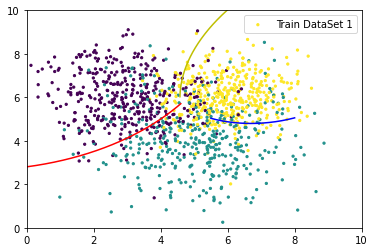

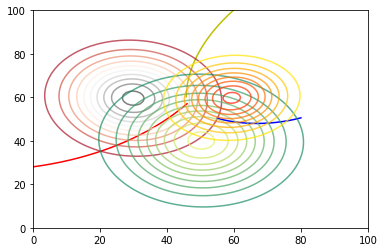

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarnin

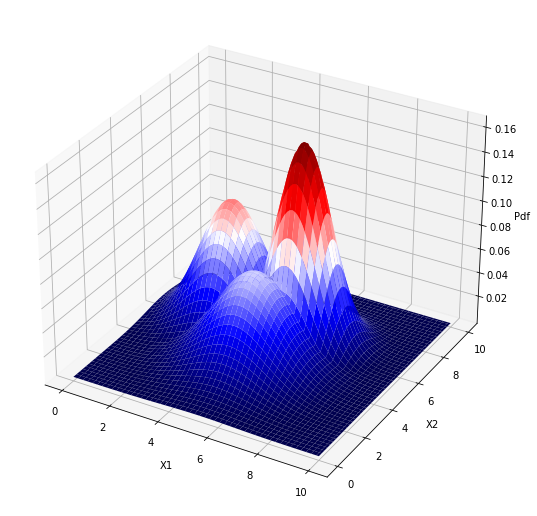

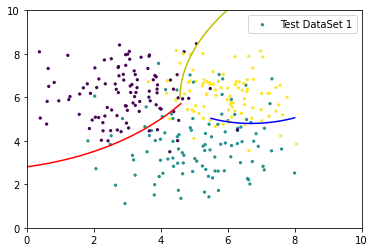

------------------------------------------------------------
fi= [[0.3325    ]
 [0.32666667]
 [0.34083333]]
mu= [[2.97693409 5.9510589 ]
 [5.07272182 3.92635284]
 [6.03361964 6.07801707]]
cov= [[[ 1.32293324  0.08371779]
  [ 0.08371779  0.47380915]]

 [[ 1.0786511  -0.20334366]
  [-0.20334366  2.11967515]]

 [[ 1.79943248 -0.26756747]
  [-0.26756747  1.39439647]]]
--------------------------DataSet2--------------------------
Train Accuracy =  0.8083333333333333
Test Accuracy =  0.8233333333333334


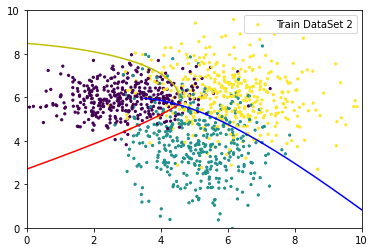

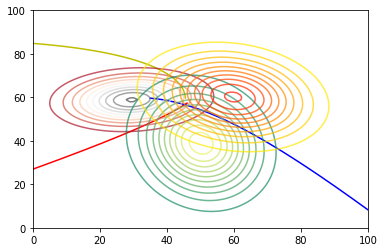

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarnin

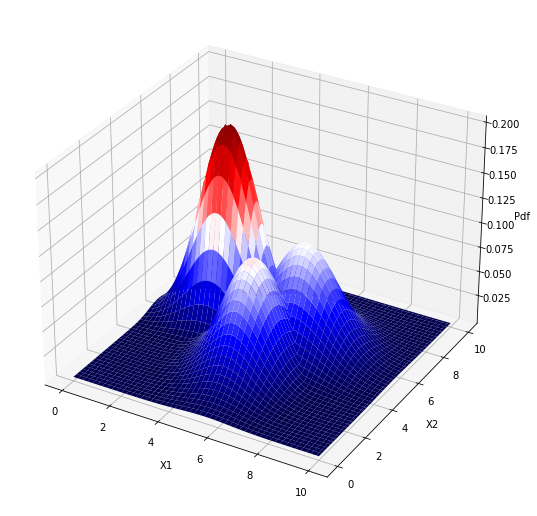

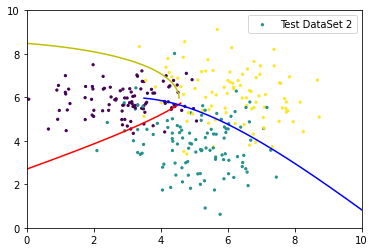

------------------------------------------------------------


In [9]:
#calculate QDA with given mu and covariance
def QDA():
    #--------------------------------DataSet1----------------------------------#
    #-----------------generateData-----------------#    
    mu1 = [3, 6]
    cov1 = [[1.5, 0  ],
            [0  , 1.5]]
    n1 = 500

    mu2 = [5, 4]
    cov2 = [[2  , 0  ],
            [0  , 2  ]] 
    n2 = 500

    mu3 = [6, 6]
    cov3 = [[1  , 0  ],
            [0  , 1  ]] 
    n3 = 500

    test_size = 0.2

    x, y, m, xtest, ytest, mtest, k = load_data(mu1, cov1, n1, mu2, cov2, n2, mu3, cov3, n3, test_size)
    #-----------------Learning-----------------#
    fi, mu, cov = qda_learn(x, y, m, k, x.shape[1])    
    #-----------------Predict------------------#
    pyx_train, y_pred_train = predict(fi, mu, cov, x, m, k)    
    pyx_test, y_pred_test  = predict(fi, mu, cov, xtest, mtest, k)
    #-----------------Results------------------#
    train_accuracy = accuracy_score(y, y_pred_train)
    test_accuracy = accuracy_score(ytest, y_pred_test)
    print('--------------------------DataSet1--------------------------')
    print('Train Accuracy = ',train_accuracy)
    print('Test Accuracy = ',test_accuracy)
    #------------------plots-------------------#    
    draw_decision_boundaries(fi, mu, cov, x, 1, 1)    
    plot_scatter(x, y, 'Train DataSet 1')
    draw_decision_boundaries(fi, mu, cov, x, 1, 10)
    plot_pdf_contour(x, mu, cov)
    plot_pdf_3d(x, mu, cov)    
    draw_decision_boundaries(fi, mu, cov, x, 1, 1)
    plot_scatter(xtest, ytest, 'Test DataSet 1')
    print('------------------------------------------------------------')
    #--------------------------------------------------------------------------#
    
    #--------------------------------DataSet2----------------------------------#
    #-----------------generateData-----------------#    
    mu1 = [3, 6]
    cov1 = [[1.5, 0.1],
            [0.1, 0.5]]
    n1 = 500

    mu2 = [5, 4]
    cov2 = [[1   , -0.2],
            [-0.2, 2   ]] 
    n2 = 500

    mu3 = [6, 6]
    cov3 = [[  2   , -0.25],
            [-0.25 , 1.5  ]] 
    n3 = 500

    test_size = 0.2

    x, y, m, xtest, ytest, mtest, k = load_data(mu1, cov1, n1, mu2, cov2, n2, mu3, cov3, n3, test_size)
    #-----------------Learning-----------------#
    fi, mu, cov = qda_learn(x, y, m, k, x.shape[1])    
    #-----------------Predict------------------#
    pyx_train, y_pred_train = predict(fi, mu, cov, x, m, k)    
    pyx_test, y_pred_test  = predict(fi, mu, cov, xtest, mtest, k)
    #-----------------Results------------------#
    train_accuracy = accuracy_score(y, y_pred_train)
    test_accuracy = accuracy_score(ytest, y_pred_test)
    print('--------------------------DataSet2--------------------------')
    print('Train Accuracy = ',train_accuracy)
    print('Test Accuracy = ',test_accuracy)
    #------------------plots-------------------#    
    draw_decision_boundaries(fi, mu, cov, x, 2, 1)    
    plot_scatter(x, y, 'Train DataSet 2')
    draw_decision_boundaries(fi, mu, cov, x, 2, 10)
    plot_pdf_contour(x, mu, cov)
    plot_pdf_3d(x, mu, cov)    
    draw_decision_boundaries(fi, mu, cov, x, 2, 1)
    plot_scatter(xtest, ytest, 'Test DataSet 2')
    print('------------------------------------------------------------')
    #--------------------------------------------------------------------------#


    
QDA()